# Exploratory data analysis - MNIST

In [1]:
# This cell assumes a project structure of: project-root/src/experiments/this_notebook.ipynb
# We append the parent directory to the system path, so now we can import modules from src
# We also create a variable named path which points to the project root.

import sys
from pathlib import Path

sys.path.append("../") # go to parent dir
path =  str(Path().resolve().parent.parent)

print(path)


/data2/Kaggle-Knowledge-Competitions


First, read the csv into Pandas to look at the structure.

In [2]:
import pandas as pd

df = pd.read_csv(path+"/data/kaggle_mnist/train.csv")
df.head()


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now, we can convert into torch Tensors, the datatype for our model

In [3]:
import torch

labels = torch.Tensor(df['label'].values)
print(labels.shape)

imgs = df.drop(labels="label", axis=1)
imgs = torch.Tensor(imgs.values)
print(imgs.shape)

imgs = imgs.unflatten(dim=1, sizes=(28,28))
print(imgs.shape)

torch.Size([42000])
torch.Size([42000, 784])
torch.Size([42000, 28, 28])


Now visualise some data, to check if everything has worked as expected.

tensor(2.)
tensor(3.)
tensor(0.)
tensor(6.)
tensor(2.)
tensor(8.)
tensor(0.)
tensor(9.)
tensor(1.)
tensor(5.)


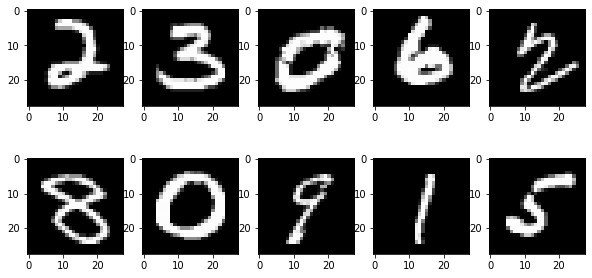

In [4]:
import matplotlib.pyplot as plt
import random

nrows=2
ncols=5
fig, axs = plt.subplots(nrows=nrows, ncols=ncols,figsize=(10,5))

for i in range(nrows):
    for j in range(ncols):
        k = random.randint(0,41999)
        axs[i,j].imshow(imgs[k].detach().numpy(),cmap="gray")
        print(labels[k])


## We've written some dataset code to do all this for us, so let's test it out

In [5]:
from datasets.kaggle_mnist import KaggleMNIST

data_train = KaggleMNIST(data_dir=path+"/data/kaggle_mnist", train=True)
data_test = KaggleMNIST(data_dir=path+"/data/kaggle_mnist", train=False)

tensor(6.)


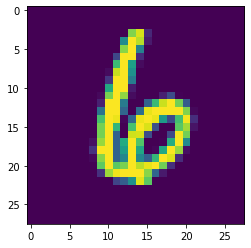

In [6]:
k = random.randint(0,41999)
plt.imshow(data_train[k][0][0].detach().numpy())
print(data_train[k][1])

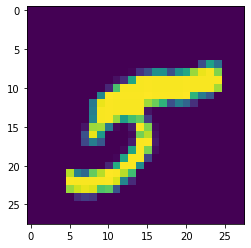

In [7]:
k = random.randint(0,41999)
plt.imshow(data_test[k][0].detach().numpy())


In [8]:
from datasets.kaggle_mnist import KaggleMNISTDataModule

datamodule = KaggleMNISTDataModule(data_dir=path+"/data/kaggle_mnist",batch_size=2, num_workers=0, drop_last=False)
datamodule.setup(stage="fit")
batch = next(iter(datamodule.train_dataloader()))
print(batch[0].shape)

torch.Size([2, 1, 28, 28])


## Now, let's take our trained model and predict for the test set

In [28]:
import pytorch_lightning as pl
from models.mnist_classifier import MNISTClassifierModule

# NOTE: assumes trained model is located in /Kaggle-Knowledge-Competitions/trained_models/mnist_classifier.ckpt
model = MNISTClassifierModule.load_from_checkpoint(path+"/trained_models/mnist_classifier.ckpt")
data = KaggleMNISTDataModule(data_dir=path+"/data/kaggle_mnist",batch_size=1, num_workers=0, drop_last=False)
data.setup()
loader = data.test_dataloader()

trainer = pl.Trainer()
preds = trainer.predict(model, loader)

# convert from torch tensors to python ints
for i in range(len(preds)):
    preds[i] = preds[i].item()

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/data2/Kaggle-Knowledge-Competitions/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1294: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  rank_zero_warn(
/data2/Kaggle-Knowledge-Competitions/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, predict dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

Now, let's quickly check if some of our test set predictions are reasonable:

Length of test set = 28000
5
1
4
2
2
6
3
8
5
6


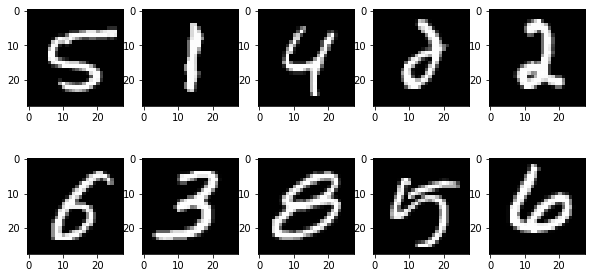

In [29]:
print(f"Length of test set = {len(preds)}")

test_imgs = data.test

import matplotlib.pyplot as plt
import random

nrows=2
ncols=5
fig, axs = plt.subplots(nrows=nrows, ncols=ncols,figsize=(10,5))

for i in range(nrows):
    for j in range(ncols):
        k = random.randint(0,28000)
        axs[i,j].imshow(test_imgs[k].squeeze().detach().numpy(),cmap="gray")
        print(preds[k])


Finally, let's save the predictions to a csv file for submission:

In [32]:
df = pd.DataFrame({"ImageId" : list(range(1, 28001)),"Label" : preds})
df.to_csv(path+"/data/kaggle_mnist/preds.csv", index=False)